In [2]:
import pickle
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load saved info
with open("classes.pkl", "rb") as f:
    classes = pickle.load(f)

with open("class_weights.pkl", "rb") as f:
    class_weights = pickle.load(f)

with open("metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

dataset_path = metadata["dataset_path"]
IMG_SIZE = metadata["IMG_SIZE"]
BATCH_SIZE = metadata["BATCH_SIZE"]

print("Classes:", classes)
print("Class Weights:", class_weights)
print("Dataset Path:", dataset_path)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class Weights: {0: np.float64(1.04437564499484), 1: np.float64(0.8412302576891105), 2: np.float64(1.0284552845528456), 3: np.float64(0.7086834733893558), 4: np.float64(0.8739205526770294), 5: np.float64(3.066666666666667)}
Dataset Path: C:\Users\Isisa\.cache\kagglehub\datasets\feyzazkefe\trashnet\versions\1\dataset-resized


In [3]:
# Train generator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

# Validation generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\Isisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,481,734 (39.98 MB)

 Trainable params: 10,481,734 (39.98 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 872ms/step - accuracy: 0.2078 - loss: 1.7839 - val_accuracy: 0.3519 - val_loss: 1.6224
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 804ms/step - accuracy: 0.3506 - loss: 1.5437 - val_accuracy: 0.3797 - val_loss: 1.5319
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 835ms/step - accuracy: 0.4098 - loss: 1.4919 - val_accuracy: 0.3618 - val_loss: 1.4988
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 744ms/step - accuracy: 0.4094 - loss: 1.4443 - val_accuracy: 0.4036 - val_loss: 1.4307
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 757ms/step - accuracy: 0.4373 - loss: 1.4049 - val_accuracy: 0.3936 - val_loss: 1.4140
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 790ms/step - accuracy: 0.4594 - loss: 1.3449 - val_accuracy: 0.4155 - val_loss: 1.4114
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 765ms/step - accuracy: 0.4656 - loss: 1.3233 - val_accuracy: 0.4115 - val_loss: 1.3728
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 763ms/step - accuracy: 0.4696 - loss: 1.2794 - val_accu

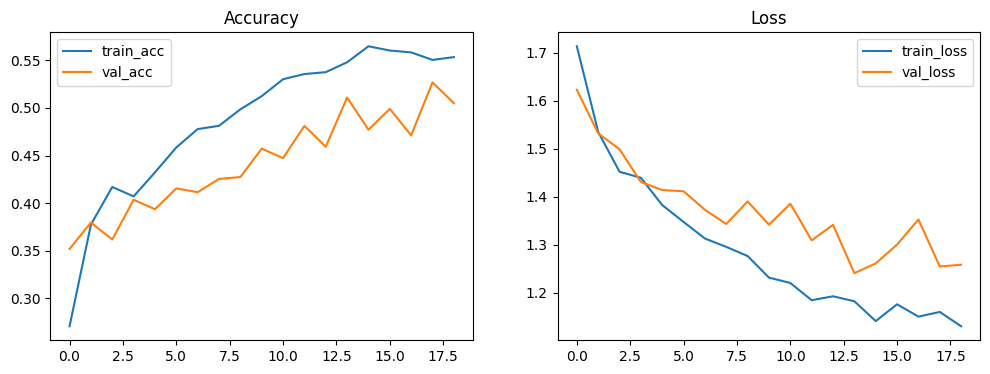

In [11]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()

plt.show()


In [12]:
# Save the model
model.save(os.path.join("models", "baseline_cnn_trashnet.h5"))

# VGG16

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze base layers initially
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)   

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 39s 1us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3008 - loss: 1.7843

64/64 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.3017 - loss: 1.7813 - val_accuracy: 0.4791 - val_loss: 1.2739
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4789 - loss: 1.3310

64/64 ━━━━━━━━━━━━━━━━━━━━ 287s 5s/step - accuracy: 0.4792 - loss: 1.3303 - val_accuracy: 0.5785 - val_loss: 1.1719
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5495 - loss: 1.1494

64/64 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.5496 - loss: 1.1494 - val_accuracy: 0.5825 - val_loss: 1.1331
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5599 - loss: 1.1287

64/64 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.5602 - loss: 1.1282 - val_accuracy: 0.5905 - val_loss: 1.0325
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6170 - loss: 0.9890

64/64 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.6170 - loss: 0.9891 - val_accuracy: 0.6143 - val_loss: 0.9714
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6367 - loss: 0.9879

64/64 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.6367 - loss: 0.9879 - val_accuracy: 0.6203 - val_loss: 0.9467
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6422 - loss: 0.9246

64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.6422 - loss: 0.9246 - val_accuracy: 0.6561 - val_loss: 0.9286
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6543 - loss: 0.9237

64/64 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.6545 - loss: 0.9232 - val_accuracy: 0.6720 - val_loss: 0.8450
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.6658 - loss: 0.8753 - val_accuracy: 0.6620 - val_loss: 0.9134
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.6669 - loss: 0.8541 - val_accuracy: 0.6501 - val_loss: 0.8936
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6970 - loss: 0.8067

64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.6970 - loss: 0.8066 - val_accuracy: 0.6978 - val_loss: 0.8098
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.7063 - loss: 0.7934 - val_accuracy: 0.6382 - val_loss: 0.9391
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.7199 - loss: 0.7457 - val_accuracy: 0.6799 - val_loss: 0.8404
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.7053 - loss: 0.8111 - val_accuracy: 0.6918 - val_loss: 0.8668
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.7451 - loss: 0.6752 - val_accuracy: 0.6899 - val_loss: 0.8883
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.7541 - loss: 0.7248 - val_accuracy: 0.7097 - val_loss: 0.8232


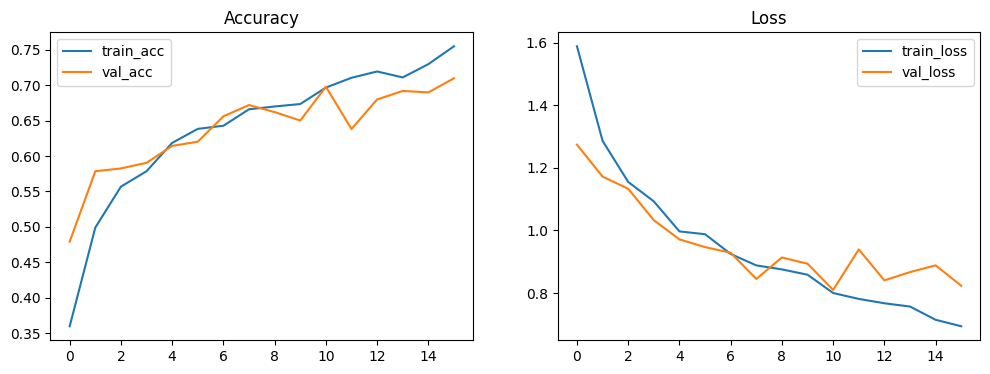

In [15]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()


In [ ]:
model.save(os.path.join("models", "vgg16_trashnet.h5"))